<a href="https://colab.research.google.com/github/yasp-g/portfolio/blob/main/Berlin-vs-DC-overcast-visualization/BER-DC-overcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Becoming an Independent Data Scientist

## Region and Domain

The region and domain of interest for the project are: **South Lyon, Michigan, United States** and **religious events or traditions**.

## Research Question

How does the 

## Data Sources

### Germany data:
#### main Page:
https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html

#### Berlin Alexanderplatz sun (from 2015 to present):
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate_urban/hourly/sun/recent/

#### Berlin Alexanderplatz sun (from 2015 to present):
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate_urban/hourly/air_temperature/recent/

### Washington, DC data:
#### Main page:
https://www.ncei.noaa.gov/cdo-web/datasets#LCD


#### Search page:
https://www.ncei.noaa.gov/cdo-web/datatools/lcd




### Sketchy link US climatology data with average sunshine
https://www2.census.gov/library/publications/2010/compendia/statab/130ed/tables/11s0394.xls

## Image

## Discussion

# Method

## Notebook Setup

### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download and import necessary libraries

In [2]:
%%capture
!pip install remotezip

In [3]:
import pandas as pd
import numpy as np
import datetime 
from remotezip import RemoteZip
from itertools import groupby
from operator import itemgetter

import matplotlib.pyplot as plt

## Load data

### Berlin Data

The Berlin data was found from Germany's Deutsche Wetterdienst [Climate Data Center](https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html). The CDC offers open access to a wide range of weather data all across Germany. One of the available weather stations is station ID 0399, in Berlin Alexanderplatz. This data is available in a remote directory, from which, sunshine duration (minutes) during each hour as far back as November 20th, 2015 is loaded below.

This data will be loaded as `df_ber`.

Sunrise and sunset data will also be needed. This was found on https://sunrise.maplogs.com.

This data will be loaded as `df_BERriseset`.


In [4]:
# define url of zipfile
zip_name = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate_urban/hourly/sun/recent/stundenwerte_sun_399_akt.zip"

# use REmoteZip to unpack and load .txt datafile from remote directory
with RemoteZip(zip_name) as ziploc:
    for zip_info in ziploc.infolist():
        # print(zip_info.filename)
        pass
    ziploc.extract('produkt_sun_399_akt.txt')

In [5]:
# read data from file
df_ber = pd.read_csv('produkt_sun_399_akt.txt', sep=';')

# strip whitespace from columns and drop 'eor' column
df_ber.rename(columns=lambda x: x.strip(), inplace=True)
df_ber.drop('eor', axis=1, inplace=True)
# df_ber.info()

In [6]:
# load data for df_BERriseset
df_BERriseset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursera Courses/Applied Data Science with Python Specialization - U Michigan/2. Applied Plotting, Charting & Data Representation in Python/Assignments/Assignment 4/Data/Berlin data/Sunshine/Sunrise&set_maplogsdotcom.csv')
# df_BERriseset

### DC Data

DC climatological data was found using Visual Crossing's [Weather Data database](https://www.visualcrossing.com/weather-data). From this database, climatological data near Washington, DC for the years 2015 to 2021 was queired and loaded below. In this queiered data is "cloudcover" as a percent, for every hour of every day. Information on the exact weather station location is not provided.

This data will be loaded as `df_dc`.

Because cloudcover accounts for clouds during the night, sunrise and sunset data will also be needed. This was found using the National Oceanic and Atmospheric Administration's [Local Climatological Data tool](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd). This data was recorded by the weather station at Washington Reagan National Airport.

This data will be loaded as `df_DCriseset`.

In [7]:
# define file path and names
drive_path = '/content/drive/MyDrive/Colab Notebooks/Coursera Courses/Applied Data Science with Python Specialization - U Michigan/2. Applied Plotting, Charting & Data Representation in Python/Assignments/Assignment 4/Data/DC data/'
dc1_file = 'washington_dc climatological 2015 to 2017.csv'
dc2_file = 'washington_dc climatological 2018 to 2021.csv'

# read files
df_dc1 = pd.read_csv(drive_path + dc1_file)
df_dc2 = pd.read_csv(drive_path + dc2_file)


In [8]:
# concatenate the two dc dataframes
df_dc = pd.concat([df_dc1, df_dc2], ignore_index=True)
# df_dc.info()

In [9]:
# load data for df_DCriseset
dc3_file = 'NOAA LCD washington daily data.csv'
df_DCriseset = pd.read_csv(drive_path + dc3_file)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (35,36,42,43,44,50,52,74,76,77,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Filter dataframe columns and rename

In [10]:
df_ber = df_ber[['MESS_DATUM', 'SONNENSCHEINDAUER']]
df_ber = df_ber.rename(columns={'MESS_DATUM': 'datetime', 'SONNENSCHEINDAUER': 'sunduration'})
df_dc = df_dc[['datetime', 'cloudcover']]

df_BERriseset = df_BERriseset.rename(columns={'Date': 'datetime', 'Sunrise': 'sunrise_BER', 'Sunset': 'sunset_BER', 'Daylength': 'daylength_BER'})
df_DCriseset = df_DCriseset[['DATE', 'Sunrise', 'Sunset']].dropna().reset_index(drop=True)
df_DCriseset = df_DCriseset.rename(columns={'DATE': 'datetime', 'Sunrise': 'sunrise_DC', 'Sunset': 'sunset_DC'})

In [11]:
# df_ber, df_dc

## Data Cleaning

The dataframes are different lengths, and neither length equals the number of hours in the intended range (begining of 2016 to end of 2021) which is 52560.

### Standardize datetime columns

In [12]:
# convert to datetime and sort df by datetime
df_ber['datetime'] = pd.to_datetime(df_ber['datetime'], format='%Y%m%d%H')
df_ber.sort_values('datetime', inplace=True)
# df_ber['datetime'].head(30)

In [13]:
# convert to datetime and sort df by datetime
df_dc['datetime'] = pd.to_datetime(df_dc['datetime'])
df_dc.sort_values('datetime', inplace=True)

In [14]:
# convert to datetime
df_BERriseset['datetime'] = pd.to_datetime(df_BERriseset['datetime'])

In [15]:
# remove the time information and keep date information
df_DCriseset['datetime'] = df_DCriseset['datetime'].str.split('T').str[0]
# convert to datetime
df_DCriseset['datetime'] = pd.to_datetime(df_DCriseset['datetime'])

### Filter date range and add year, month, day, hour columns

In [16]:
startdate = pd.to_datetime('1/1/2016')
enddate = pd.to_datetime('1/1/2022')
df_ber = df_ber[(df_ber['datetime'] >= startdate) & (df_ber['datetime'] < enddate)].reset_index(drop=True)
# df_ber['year'] = df_ber['datetime'].dt.year
# df_ber['month'] = df_ber['datetime'].dt.month
# df_ber['day'] = df_ber['datetime'].dt.day
# df_ber['hour'] = df_ber['datetime'].dt.hour
# df_ber

df_dc = df_dc[(df_dc['datetime'] >= startdate) & (df_dc['datetime'] < enddate)].reset_index(drop=True)
# df_dc['year'] = df_dc['datetime'].dt.year
# df_dc['month'] = df_dc['datetime'].dt.month
# df_dc['day'] = df_dc['datetime'].dt.day
# df_dc['hour'] = df_dc['datetime'].dt.hour
# df_dc

# df_DCriseset['year'] = df_DCriseset['datetime'].dt.year
# df_DCriseset['month'] = df_DCriseset['datetime'].dt.month
# df_DCriseset['day'] = df_DCriseset['datetime'].dt.day
# df_DCriseset

len(df_ber), len(df_dc), len(df_BERriseset), len(df_DCriseset)

(50269, 52608, 2192, 2192)

### Remove Febuary 29th from data

In [17]:
df_ber = df_ber.drop(df_ber[(df_ber['datetime'].dt.month == 2) & 
                   (df_ber['datetime'].dt.day == 29)].index).reset_index(drop=True)
df_dc = df_dc.drop(df_dc[(df_dc['datetime'].dt.month == 2) & 
                 (df_dc['datetime'].dt.day == 29)].index).reset_index(drop=True)
df_BERriseset = df_BERriseset.drop(df_BERriseset[(df_BERriseset['datetime'].dt.month == 2) & 
                        (df_BERriseset['datetime'].dt.day == 29)].index).reset_index(drop=True)
df_DCriseset = df_DCriseset.drop(df_DCriseset[(df_DCriseset['datetime'].dt.month == 2) & 
                       (df_DCriseset['datetime'].dt.day == 29)].index).reset_index(drop=True)

len(df_ber), len(df_dc), len(df_BERriseset), len(df_DCriseset)

(50221, 52560, 2190, 2190)

In [18]:
# old method for removing lead day data:

# df_ber = df_ber[~((df_ber['month'] == 2) & (df_ber['day'] == 29))].reset_index(drop=True)
# df_dc = df_dc[~((df_dc['month'] == 2) & (df_dc['day'] == 29))].reset_index(drop=True)
# df_DCriseset = df_DCriseset[~((df_DCriseset['month'] == 2) & (df_DCriseset['day'] == 29))].reset_index(drop=True)
# len(df_ber), len(df_dc), len(df_DCriseset)

### Duplicate Rows found in `dc_df`

During the following "Dealing with missing rows" section, `dc_df` was found to have dupplicate datetime instances. This needs to be fixed first.

In [19]:
dc_datevc = df_dc['datetime'].value_counts()
print(dc_datevc[dc_datevc > 1])

2019-11-03 01:00:00    2
2020-11-01 01:00:00    2
2016-11-06 01:00:00    2
2018-11-04 01:00:00    2
2017-11-05 01:00:00    2
2021-11-07 01:00:00    2
Name: datetime, dtype: int64


In [20]:
print(df_dc[df_dc['datetime'] == '2019-11-03 01:00:00'])
print(df_dc[df_dc['datetime'] == '2018-11-04 01:00:00'])
print(df_dc[df_dc['datetime'] == '2016-11-06 01:00:00'])
print(df_dc[df_dc['datetime'] == '2018-11-04 01:00:00'])
print(df_dc[df_dc['datetime'] == '2017-11-05 01:00:00'])
print(df_dc[df_dc['datetime'] == '2021-11-07 01:00:00'])

                 datetime  cloudcover
33624 2019-11-03 01:00:00         0.0
33625 2019-11-03 01:00:00         0.0
                 datetime  cloudcover
24888 2018-11-04 01:00:00         0.0
24889 2018-11-04 01:00:00         0.0
                datetime  cloudcover
7416 2016-11-06 01:00:00         0.0
7417 2016-11-06 01:00:00         0.0
                 datetime  cloudcover
24888 2018-11-04 01:00:00         0.0
24889 2018-11-04 01:00:00         0.0
                 datetime  cloudcover
16152 2017-11-05 01:00:00       100.0
16153 2017-11-05 01:00:00       100.0
                 datetime  cloudcover
51240 2021-11-07 01:00:00        79.3
51241 2021-11-07 01:00:00        90.1


During an earlier check, it was confirmed that each year had the appropriate number of values... (there are 8760 hours in a year)

Shown again:

In [21]:
for year in range(2016, 2022):
  print("year:", year)
  print("rows:", len(df_dc[df_dc['datetime'].dt.year == year]))


year: 2016
rows: 8760
year: 2017
rows: 8760
year: 2018
rows: 8760
year: 2019
rows: 8760
year: 2020
rows: 8760
year: 2021
rows: 8760


So, each year has the appropriate number of timestamps, yet every year has a duplicate time stamp in November.

After some investigation, each year was found to be missing a timestamp in march:

In [22]:
# create a date range with all hours in the target range and lead days removed
daterange = pd.date_range(start='2016-01-01', end='2022-01-01', freq='H', closed='left')
leap=[]
for stamp in daterange:
    if stamp.month==2 and stamp.day ==29:
        leap.append(stamp)
daterange = daterange.drop(leap)

# check the difference between the date range and df_dc range
# this will show any missing values
daterange.difference(df_dc['datetime'])

DatetimeIndex(['2016-03-13 02:00:00', '2017-03-12 02:00:00',
               '2018-03-11 02:00:00', '2019-03-10 02:00:00',
               '2020-03-08 02:00:00', '2021-03-14 02:00:00'],
              dtype='datetime64[ns]', freq=None)

In [23]:
# df_dc[(df_dc['year'] == 2016) & (df_dc['month'] == 3)]

# df_dc[(df_dc['year'] == 2016) & (df_dc['month'] == 11)]

At this point, the proper step would be to contact the data provider to gain some context as to what may be causing this issue and determine a path forward together. 

For the sake of this project, it will be interpreted that all time stamps between the missing timestamp in March and the duplicate timestamp in November are one hour "late". All timestamps in this range will be shifted forwards one hour (only the first instance of a duplicated timestamp will be shifted).

#### Shifting offset timestamps

In [24]:
# get missing times from march and duplicate times from november in lists
miss_times = daterange.difference(df_dc['datetime']).sort_values()
dc_datevc = df_dc['datetime'].value_counts()
dup_times = dc_datevc[dc_datevc > 1].index.sort_values()

# iterate over zip of missing and duplicate times and shift timestamps inbetween by 1 hour
for year in zip(miss_times, dup_times):
  # print(f'Missing March hour: {year[0]}')
  # print(f'Duplicate Nov hour: {year[1]}')
  df_dc.datetime = df_dc.datetime.map(lambda x: x - pd.Timedelta(1, 'h') if 
                                      (year[0] < x) & (x < year[1]) else x)
# print('')

# shift the first occurance of each duplicate timestamp forward one hour
for duplicate in dup_times:
  if dup_times.empty:
    break
  # print(df_dc[df_dc['datetime'] == duplicate])
  index = df_dc.index[df_dc['datetime'] == duplicate][0]
  # print(f"Index: {index}")
  # print(f"Value before: {df_dc['datetime'].iloc[index]}")
  df_dc.loc[index, 'datetime'] -=  pd.Timedelta(1, 'h')
  # print(f"Value after: {df_dc['datetime'].iloc[index]}")

In [25]:
daterange.difference(df_dc['datetime']).sort_values()

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [26]:
df_dc['datetime'].value_counts()

2016-01-01 00:00:00    1
2020-01-01 05:00:00    1
2019-12-31 19:00:00    1
2019-12-31 20:00:00    1
2019-12-31 21:00:00    1
                      ..
2018-01-01 01:00:00    1
2018-01-01 02:00:00    1
2018-01-01 03:00:00    1
2018-01-01 04:00:00    1
2021-12-31 23:00:00    1
Name: datetime, Length: 52560, dtype: int64

### Dealing with missing rows in `df_ber` and creating `df`

`df_ber` only has 50221 rows. To make investigating this a little easier, the datetime series with all hours in the target date range created earlier will be used as the foundation of a dataframe into which, both `df_ber` and `df_dc` will be left merged. This dataframe will be called `df`.

In [27]:
df = pd.DataFrame(daterange, columns=['datetime'])
df = pd.merge(df, df_ber[['datetime', 'sunduration']], how='left', on='datetime')
df = pd.merge(df, df_dc[['datetime', 'cloudcover']], how='left', on='datetime')
df = df.rename(columns={'sunduration': 'sunduration_BER', 'cloudcover': 'cloudcover_DC'})
# df

In [28]:
df

,datetime,sunduration_BER,cloudcover_DC
0,2016-01-01 00:00:00,0.0,99.8
1,2016-01-01 01:00:00,0.0,100.0
2,2016-01-01 02:00:00,0.0,88.9
3,2016-01-01 03:00:00,0.0,79.3
4,2016-01-01 04:00:00,0.0,79.3
...,...,...,...
52555,2021-12-31 19:00:00,0.0,81.7
52556,2021-12-31 20:00:00,0.0,98.3
52557,2021-12-31 21:00:00,0.0,99.6
52558,2021-12-31 22:00:00,0.0,99.6


Most of the missing data is in the form of consecutive missing hours. For example, starting on May 25th, 2020, more than an entire month straight is missing (923 consecutive hours). 

In [29]:
# get the rows where sunduration is nan
no_sun_ind = df[df.isnull().any(axis=1)].index
print(len(no_sun_ind))

2339


In [30]:
# create a series of tuples
no_sun_segments = []
for k, g in groupby(enumerate(no_sun_ind), lambda ix : ix[0] - ix[1]):
  # print("Values:")
  series = list(map(itemgetter(1), g))
  # print(series)
  # print(f"Number of values: {len(list(map(itemgetter(1), g)))}")
  no_sun_segments.append((len(series), series))

print(*no_sun_segments[:10], sep='\n')

(1, [2577])
(23, [3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039])
(1, [3401])
(1, [3648])
(2, [3712, 3713])
(1, [3790])
(2, [4169, 4170])
(4, [4191, 4192, 4193, 4194])
(1, [4215])
(14, [4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316])


The goal of this project is to compare monthy averages between Berlin and Washington, DC. So it's not very necesary to fill these large segments of missing data. As shown below, all months have atleast 80% of total possible data available. 

Smaller segments of missing data (1 or 2 consecutive hours) will be replaced by averaging the preceding and following readings. This accounts for 5.86% of the missing data.

In [31]:
# dict of months with their total hours as values
month_hours = {1: 4464, 2: 4032, 3: 4464, 4: 4320, 5: 4464, 6: 4320, 7: 4464, 8: 4464, 9: 4320, 10: 4464, 11: 4320, 12:4464}

for month in range(1, 13):
  print("month:", month)
  vals_count = len(df[df['datetime'].dt.month == month].dropna())
  print("Num of values:", vals_count)
  print("% of data available:", round((vals_count / month_hours[month] * 100), 1))
  print("")

month: 1
Num of values: 4460
% of data available: 99.9

month: 2
Num of values: 3864
% of data available: 95.8

month: 3
Num of values: 4453
% of data available: 99.8

month: 4
Num of values: 4223
% of data available: 97.8

month: 5
Num of values: 4147
% of data available: 92.9

month: 6
Num of values: 3456
% of data available: 80.0

month: 7
Num of values: 4183
% of data available: 93.7

month: 8
Num of values: 4187
% of data available: 93.8

month: 9
Num of values: 4273
% of data available: 98.9

month: 10
Num of values: 4268
% of data available: 95.6

month: 11
Num of values: 4304
% of data available: 99.6

month: 12
Num of values: 4403
% of data available: 98.6



In [32]:
ones_and_twos_count = 0
for segment in no_sun_segments:
  if segment[0] == 1:
    ones_and_twos_count += 1
  elif segment[0] == 2:
    ones_and_twos_count += 2
print("Total rows from single or double missing segments:", ones_and_twos_count)
print("Percent of missing rows made up of single or double segments:", 
      round((ones_and_twos_count / len(no_sun_ind) * 100), 2))

Total rows from single or double missing segments: 137
Percent of missing rows made up of single or double segments: 5.86


#### Filling single and double missing segments in `sunduration`

Occurances of just one or two consecutive missing readings will be filled with the average of the preceading and following readings.

In [33]:
for segment in no_sun_segments:
  if segment[0] == 1:
    preceding = df.loc[segment[1][0] - 1, 'sunduration_BER']
    following = df.loc[segment[1][0] + 1, 'sunduration_BER']
    df.loc[segment[1], 'sunduration_BER'] = (preceding + following) * 0.5
  elif segment[0] == 2:
    preceding = df.loc[segment[1][0] - 1, 'sunduration_BER']
    following = df.loc[segment[1][1] + 1, 'sunduration_BER']
    df.loc[segment[1][0], 'sunduration_BER'] = (preceding + following) * 0.5
    df.loc[segment[1][1], 'sunduration_BER'] = (preceding + following) * 0.5

### Setting `df['datetime']` as `df.index` 

This will make using the `pd.groupby()` method easier during the **Data Analysis** section below.



In [34]:
df.set_index('datetime', inplace=True)
df

,sunduration_BER,cloudcover_DC
datetime,,
2016-01-01 00:00:00,0.0,99.8
2016-01-01 01:00:00,0.0,100.0
2016-01-01 02:00:00,0.0,88.9
2016-01-01 03:00:00,0.0,79.3
2016-01-01 04:00:00,0.0,79.3
...,...,...
2021-12-31 19:00:00,0.0,81.7
2021-12-31 20:00:00,0.0,98.3
2021-12-31 21:00:00,0.0,99.6


### Prepping `df_DCriseset` and `df_BERriseset` and creating `df_riseset`

These two dataframes need to be standardized in order to be used. After doing so they will be combined into one dataframe, `df_riseset`

In [35]:
df_BERriseset.head(), df_DCriseset.head()

(    datetime sunrise_BER  sunset_BER daylength_BER
 0 2016-01-01  8:16:40 AM  4:02:43 PM     7h 46m 3s
 1 2016-01-02  8:16:31 AM  4:03:49 PM    7h 47m 18s
 2 2016-01-03  8:16:18 AM  4:04:57 PM    7h 48m 39s
 3 2016-01-04  8:16:01 AM  4:06:08 PM     7h 50m 7s
 4 2016-01-05  8:15:41 AM  4:07:22 PM    7h 51m 41s,
     datetime  sunrise_DC  sunset_DC
 0 2016-01-01       727.0     1657.0
 1 2016-01-02       727.0     1658.0
 2 2016-01-03       727.0     1659.0
 3 2016-01-04       727.0     1700.0
 4 2016-01-05       727.0     1700.0)

In [36]:
df_BERriseset['sunrise_BER'] = pd.to_datetime(df_BERriseset['sunrise_BER'], format='%I:%M:%S %p').dt.time
df_BERriseset['sunset_BER'] = pd.to_datetime(df_BERriseset['sunset_BER'], format='%I:%M:%S %p').dt.time

df_DCriseset['sunrise_DC'] = pd.to_datetime(df_DCriseset['sunrise_DC'], format='%H%M').dt.time
df_DCriseset['sunset_DC'] = pd.to_datetime(df_DCriseset['sunset_DC'], format='%H%M').dt.time

In [37]:
df_riseset = pd.merge(df_BERriseset, df_DCriseset, how='inner', on='datetime')
df_riseset

,datetime,sunrise_BER,sunset_BER,daylength_BER,sunrise_DC,sunset_DC
0,2016-01-01,08:16:40,16:02:43,7h 46m 3s,07:27:00,16:57:00
1,2016-01-02,08:16:31,16:03:49,7h 47m 18s,07:27:00,16:58:00
2,2016-01-03,08:16:18,16:04:57,7h 48m 39s,07:27:00,16:59:00
3,2016-01-04,08:16:01,16:06:08,7h 50m 7s,07:27:00,17:00:00
4,2016-01-05,08:15:41,16:07:22,7h 51m 41s,07:27:00,17:00:00
...,...,...,...,...,...,...
2185,2021-12-27,08:16:59,15:58:30,7h 41m 31s,07:25:00,16:53:00
2186,2021-12-28,08:17:05,15:59:22,7h 42m 17s,07:26:00,16:54:00
2187,2021-12-29,08:17:08,16:00:17,7h 43m 9s,07:26:00,16:54:00
2188,2021-12-30,08:17:07,16:01:16,7h 44m 9s,07:26:00,16:55:00


### Creating `sunup_BER` and `sunup_DC`
The goal of this project is to compare overcast between the two cities, therefore, the sunrise and sunset times of each day will need to be taken into account. To do this binary `sunup_BER` and `sunup_DC` coulmns will be created and added to `df`, denoting if the sun was in the sky for any amount of time during the `datetime` hour.

Presently, `cloudcover_DC` has values for all hours of the day, as it only accounts for clouds, and not whether the clouds are blocking possible sunshine. Adding `sunup_DC` will make it possible to compare `cloudcover_DC` to `sunduration_BER`, as it will allow `df` to be filtered for when the sun is up or down. `sunup_DC` will also be needed later during the **Data Analysis** section of the notebook when preparing data for the visualization.


## DELETE:

The following changes will be made:

-  sunrise and sunset data will be use to set `cloudcover` to 0 when the sun is down
- during hours where the sun rose and set, `cloudcover_dc` will be multiplied by ratio of minutes that the sun was up to the total minutes in an hour
  - for example:
    - on 2016-01-01, the sun rose at 7:27 and set at 16:57 in DC
    - during 2016-01-01 07:00:00, `cloudcover_DC` is 96.6% and during 2016-01-01 16:00:00 it is 89.1%
    - these 96.6% and 89.1% `cloudcover_dc` values will become 53.13% and 84.645%
  - this 

In [38]:
def sun_up_check(row):
  sunrise_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_BER'].values[0]
  sunset_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_BER'].values[0]
  sunrise_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_DC'].values[0]
  sunset_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_DC'].values[0]

  sunup_BER = 0
  sunup_DC = 0
  
  if (sunrise_BER.hour <= row.name.hour) and (sunset_BER.hour >= row.name.hour):
      sunup_BER = 1
  if (sunrise_DC.hour <= row.name.hour) and (sunset_DC.hour >= row.name.hour):
      sunup_DC = 1
      
  return sunup_BER, sunup_DC


# for i in range(0,24):
#   print(sun_up_check(df.loc[i]))

In [39]:
df[['sunup_BER', 'sunup_DC']] = df.apply(sun_up_check, axis=1, result_type='expand')
df

,sunduration_BER,cloudcover_DC,sunup_BER,sunup_DC
datetime,,,,
2016-01-01 00:00:00,0.0,99.8,0,0
2016-01-01 01:00:00,0.0,100.0,0,0
2016-01-01 02:00:00,0.0,88.9,0,0
2016-01-01 03:00:00,0.0,79.3,0,0
2016-01-01 04:00:00,0.0,79.3,0,0
...,...,...,...,...
2021-12-31 19:00:00,0.0,81.7,0,0
2021-12-31 20:00:00,0.0,98.3,0,0
2021-12-31 21:00:00,0.0,99.6,0,0


## Data Analysis

The data in `df` isn't ready to be compared yet, as `sunduration_BER` represents minutes of sunshine during each hour and `cloudcover_DC` represents a percentage of overcast for each hour. To prepare the data for visual comparison, a `sunduration` and `cloudcover` column will be created for both cities. 

`cloudcover_BER` will be created by dividing `sunduration_BER` values by the minutes during the hour where the sun was up. This will be an approximation of the percentage of sunshine in an hour. Note that during the house where the rose and set, this factor will not be 60.

`sunduratino_DC` will be calculated from `cloudcover_DC` using the opposite transformation: multiplying the percentages by minutes in the hour where the sun was up. This will be an approximation of the minutes during each hour that the sun was shining.

Values will not be rounded.

In [96]:
def sundur_to_cloudcover(row):
  if not row['sunup_BER']:
    return None

  sunrise_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_BER'].values[0]
  sunset_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_BER'].values[0]

  if row.name.hour == sunrise_BER.hour:
    min_sun = 60.0 - sunrise_BER.minute + sunrise_BER.second
    return  100 - row['sunduration_BER'] / min_sun * 100
  elif row.name.hour == sunset_BER.hour:
      min_sun = sunset_BER.minute + sunset_BER.second
      return 100 - row['sunduration_BER']  / min_sun * 100
  return 100 - row['sunduration_BER'] / 60.0 * 100

def cloudcover_to_sundur(row):
  if not row['sunup_DC']:
    return 0

  sunrise_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_DC'].values[0]
  sunset_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_DC'].values[0]

  if row.name.hour == sunrise_DC.hour:
    min_sun = 60.0 - sunrise_DC.minute
    return row['cloudcover_DC'] * min_sun / 100
  elif row.name.hour == sunset_DC.hour:
      min_sun = sunset_DC.minute
      return row['cloudcover_DC'] * min_sun / 100
  else:
    return row['cloudcover_DC'] * 60.0 / 100
    
def transform_sundur_cloudcov2(row):
  return sundur_to_cloudcover(row), cloudcover_to_sundur(row)


def OLD_transform_sundur_cloudcov(row):
  sunrise_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_BER'].values[0]
  sunset_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_BER'].values[0]
  sunrise_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_DC'].values[0]
  sunset_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_DC'].values[0]

  cloudcover_BER = 0
  sunduration_DC = 0

  if row['sunup_BER']:
    if row.name.hour == sunrise_BER.hour:
      min_sun = 60.0 - sunrise_BER.minute + sunrise_BER.second
      cloudcover_BER =  100 - row['sunduration_BER'] / min_sun * 100
    elif row.name.hour == sunset_BER.hour:
        min_sun = sunset_BER.minute + sunset_BER.second
        cloudcover_BER = 100 - row['sunduration_BER']  / min_sun * 100  
    else:
      cloudcover_BER = 100 - row['sunduration_BER'] / 60.0 * 100
  else:
    cloudcover_BER = None
    
  if row['sunup_DC']:
    if row.name.hour == sunrise_DC.hour:
      min_sun = 60.0 - sunrise_DC.minute
      sunduration_DC = row['cloudcover_DC'] * min_sun / 100
    elif row.name.hour == sunset_DC.hour:
        min_sun = sunset_DC.minute
        sunduration_DC = row['cloudcover_DC'] * min_sun / 100
    else:
      sunduration_DC = row['cloudcover_DC'] * 60.0 / 100
  else:
    sunduration_DC = 0

  return cloudcover_BER, sunduration_DC

In [107]:
%%time
# apply the transform function defined above
df[['cloudcover_BER', 'sunduration_DC']] = df.apply(transform_sundur_cloudcov, axis=1, result_type='expand')
# reorder the columns so cities are together and observation type is in same order
df = df[['sunup_BER', 'sunduration_BER', 'cloudcover_BER', 'sunup_DC', 'sunduration_DC',  'cloudcover_DC']]

CPU times: user 1min 2s, sys: 114 ms, total: 1min 2s
Wall time: 1min 2s


In [108]:
%%time
# apply the transform function defined above
df[['cloudcover_BER', 'sunduration_DC']] = df.apply(transform_sundur_cloudcov2, axis=1, result_type='expand')
# reorder the columns so cities are together and observation type is in same order
df = df[['sunup_BER', 'sunduration_BER', 'cloudcover_BER', 'sunup_DC', 'sunduration_DC',  'cloudcover_DC']]

CPU times: user 36.6 s, sys: 74.3 ms, total: 36.7 s
Wall time: 36.7 s


In [109]:
df

,sunup_BER,sunduration_BER,cloudcover_BER,sunup_DC,sunduration_DC,cloudcover_DC
datetime,,,,,,
2016-01-01 00:00:00,0,0.0,NaN,0,0.0,99.8
2016-01-01 01:00:00,0,0.0,NaN,0,0.0,100.0
2016-01-01 02:00:00,0,0.0,NaN,0,0.0,88.9
2016-01-01 03:00:00,0,0.0,NaN,0,0.0,79.3
2016-01-01 04:00:00,0,0.0,NaN,0,0.0,79.3
...,...,...,...,...,...,...
2021-12-31 19:00:00,0,0.0,NaN,0,0.0,81.7
2021-12-31 20:00:00,0,0.0,NaN,0,0.0,98.3
2021-12-31 21:00:00,0,0.0,NaN,0,0.0,99.6


### Gather data needed for isualization
- average cloud cover by month
  - `clouds_month_BER` and `clouds_month_DC`
- average total minutes of sunshine (in a day) by month
  - `sundur_month_BER` and `sundur_month_DC`

In [43]:
clouds_BER = df[['cloudcover_BER']][df['sunup_BER'] == 1]
clouds_month_BER = clouds_BER.groupby(clouds_BER.index.month).agg({'cloudcover_BER': np.mean})
clouds_month_BER.index.names = ['month']
print(clouds_month_BER)
clouds_DC = df[['cloudcover_DC']][df['sunup_DC'] == 1]
clouds_month_DC = clouds_DC.groupby(clouds_DC.index.month).agg({'cloudcover_DC': np.mean})
clouds_month_DC.index.names = ['month']
print(clouds_month_DC)

       cloudcover_BER
month                
1           90.882637
2           78.391219
3           76.531243
4           61.884438
5           70.419359
6           68.448331
7           72.656937
8           69.988697
9           70.652112
10          83.738057
11          90.229341
12          91.946135
       cloudcover_DC
month               
1          66.343984
2          70.540373
3          63.651969
4          65.141435
5          68.949416
6          63.374653
7          58.595392
8          60.801553
9          63.209301
10         63.433961
11         58.977817
12         69.214032


In [44]:
sundur_BER = df[['sunduration_BER']][df['sunup_BER'] == 1]
sundur_day_BER = sundur_BER.groupby([sundur_BER.index.year, sundur_BER.index.month, sundur_BER.index.day]).agg({'sunduration_BER': np.sum})
sundur_day_BER.index.names = ['year', 'month', 'day']
sundur_month_BER = sundur_day_BER.groupby(level=['month']).agg({'sunduration_BER': np.mean})
print(sundur_month_BER)
sundur_DC = df[['sunduration_DC']][df['sunup_DC'] == 1]
sundur_day_DC = sundur_DC.groupby([sundur_DC.index.year, sundur_DC.index.month, sundur_DC.index.day]).agg({'sunduration_DC': np.sum})
sundur_day_DC.index.names = ['year', 'month', 'day']
sundur_month_DC = sundur_day_DC.groupby(level=['month']).agg({'sunduration_DC': np.mean})
print(sundur_month_DC)

       sunduration_BER
month                 
1            50.704301
2           135.523810
3           182.970430
4           335.891667
5           274.768817
6           272.080556
7           265.317204
8           261.260753
9           236.766667
10          106.284946
11           57.388889
12           38.632432
       sunduration_DC
month                
1          391.051323
2          455.265940
3          458.373581
4          518.932672
5          592.161215
6          565.076478
7          513.794048
8          497.725081
9          473.047794
10         424.563247
11         356.687806
12         394.278473


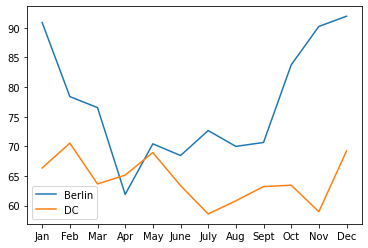

In [45]:
# define a figure and axes abject
fig, ax = plt.subplots()

# plt.xlim([-1,4])

# define list from 1 to 12
x_pos = list(range(1, 13))
# define list of month names
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
# define x_ticks and assign the month names as labels
ax.set_xticks(x_pos)
ax.set_xticklabels(months)

plt.plot(x_pos, clouds_month_BER, label='Berlin')
plt.plot(x_pos, clouds_month_DC, label='DC')

plt.legend()

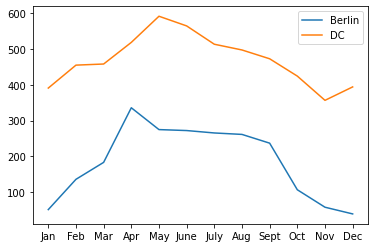

In [46]:
# define a figure and axes abject
fig1, ax1 = plt.subplots()

# plt.xlim([-1,4])

# define list from 1 to 12
x_pos = list(range(1, 13))
# define list of month names
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
# define x_ticks and assign the month names as labels
ax1.set_xticks(x_pos)
ax1.set_xticklabels(months)

plt.plot(x_pos, sundur_month_BER, label='Berlin')
plt.plot(x_pos, sundur_month_DC, label='DC')

plt.legend()

# Experimenting:::

In [68]:
sun_percent_BER = 100 - clouds_month_BER
# sun_percent_BER = sun_percent_BER / sun_percent_BER.max()
sun_percent_DC =  100 - clouds_month_DC 
# sun_percent_DC = sun_percent_DC / sun_percent_DC.max()

sundur_percent_BER = sundur_month_BER / sundur_month_BER.max() * 100
sundur_percent_DC = sundur_month_DC / sundur_month_DC.max() * 100

In [61]:
sun_percent_BER

,cloudcover_BER
month,
1,9.117363
2,21.608781
3,23.468757
4,38.115562
5,29.580641
6,31.551669
7,27.343063
8,30.011303
9,29.347888


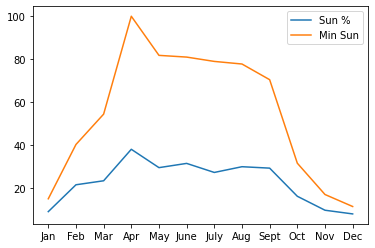

In [62]:
# define a figure and axes abject
fig2, ax2 = plt.subplots()

# plt.xlim([-1,4])

# define list from 1 to 12
x_pos = list(range(1, 13))
# define list of month names
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
# define x_ticks and assign the month names as labels
ax2.set_xticks(x_pos)
ax2.set_xticklabels(months)

plt.plot(x_pos, sun_percent_BER, label='Sun %')
plt.plot(x_pos, sundur_percent_BER, label='Min Sun')

plt.legend()

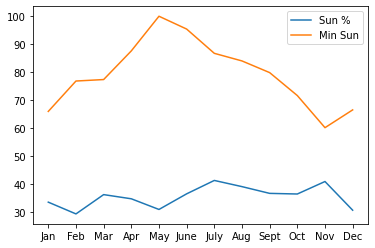

In [69]:
# define a figure and axes abject
fig3, ax3 = plt.subplots()

# plt.xlim([-1,4])

# define list from 1 to 12
x_pos = list(range(1, 13))
# define list of month names
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
# define x_ticks and assign the month names as labels
ax3.set_xticks(x_pos)
ax3.set_xticklabels(months)

plt.plot(x_pos, sun_percent_DC, label='Sun %')
plt.plot(x_pos, sundur_percent_DC, label='Min Sun')

plt.legend()

In [83]:
test_clouds_BER = df[['cloudcover_BER']][df['sunup_BER'] == 1]
test_clouds_month_BER = test_clouds_BER.groupby([test_clouds_BER.index.year, test_clouds_BER.index.month]).agg({'cloudcover_BER': np.mean})
test_clouds_month_BER.index.names = ['year', 'month']
# print(test_clouds_month_BER)
test_clouds_DC = df[['cloudcover_DC']][df['sunup_DC'] == 1]
test_clouds_month_DC = test_clouds_DC.groupby([test_clouds_DC.index.year, test_clouds_DC.index.month]).agg({'cloudcover_DC': np.mean})
test_clouds_month_DC.index.names = ['year', 'month']
# print(clouds_month_DC)

test_clouds_month_BER.index = test_clouds_month_BER.index.get_level_values('month')
test_clouds_month_DC.index = test_clouds_month_DC.index.get_level_values('month')

print("Berlin")
for i in range(1, 13):
  print(months[i - 1])
  print(test_clouds_month_BER.loc[i])

print(" ")
print("DC")
for i in range(1, 13):
  print(months[i - 1])
  print(test_clouds_month_DC.loc[i])

Berlin
Jan
       cloudcover_BER
month                
1           89.982578
1           87.309028
1           95.162602
1           89.396051
1           88.826945
1           94.618056
Feb
       cloudcover_BER
month                
2           85.925926
2           85.756071
2           66.021259
2           70.407166
2           87.830579
2           76.109272
Mar
       cloudcover_BER
month                
3           80.988224
3           74.483809
3           76.507937
3           84.016555
3           74.568879
3           68.658824
Apr
       cloudcover_BER
month                
4           67.957571
4           75.186412
4           54.523574
4           50.978870
4           51.737655
4           69.660622
May
       cloudcover_BER
month                
5           67.132380
5           73.740688
5           58.983740
5           77.667997
5           72.363614
5           72.884615
June
       cloudcover_BER
month                
6           70.968647
6           73.675084
